# Assignment 3: Explainable AI - kelvin.ahiakpor

## Characterisation of Covid-19 Vaccinated Profiles Regarding Break-through Infection using Explainable Unsupervised Learning

### Imports

In [1]:
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from IPython.display import display, Markdown
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import silhouette_score, calinski_harabasz_score

### Setting job timeout for computation

In [2]:
os.environ['JOBLIB_START_METHOD'] = 'loky'
os.environ['JOBLIB_TIMEOUT'] = '300'

### Loading data

In [3]:
raw_file_url = 'https://raw.githubusercontent.com/kelvin-ahiakpor/Explainable_AI/main/Data_Combined.xlsx' 

vaccines = pd.read_excel(raw_file_url, engine='openpyxl')

### Understanding the data

##### Custom recipes for Data Loading and Inspection

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3) 

##### Peek at training data

In [5]:
print(f"Dimensions of data set is {vaccines.shape} This is a fairly small dataset.\n")
vaccines.info()
vaccines.head()

Dimensions of data set is (258, 60) This is a fairly small dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Patient_Number                258 non-null    int64 
 1   Glucose_Level                 258 non-null    int64 
 2   Cholestrol                    258 non-null    int64 
 3   Temp                          258 non-null    int64 
 4   Weight                        258 non-null    int64 
 5   BMI                           258 non-null    int64 
 6   Height                        258 non-null    int64 
 7   Waist_circumference           258 non-null    int64 
 8   HB                            258 non-null    int64 
 9   Gender_x                      258 non-null    int64 
 10  Age                           258 non-null    int64 
 11  HLE                           258 non-null    int64 
 12  Smoking  

,Patient_Number,Glucose_Level,Cholestrol,Temp,Weight,BMI,Height,Waist_circumference,HB,Gender_x,Age,HLE,Smoking,Physical_activity,PA/week,PA level,HPT,Low/high_Blood_sugar,Fam_hx_CVD,High_Chol,Kidney_problems,Liver_problems,Gender_y,Participant_Number,Age_of_Participant_b,Vaccine_Type,Vaccination_Status,Number_of_Doses,Boosting_Status,Side_Effects,Symptoms_and_Treatment,Hospitalization,Co-Morbidities,BP_Average,Weight_Category,Occupation,Marital_status,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,Symp_Cold_i,Symp_Cough_i,Symp_Sore_throat_i,Symp_Headache_i,breathlessness_i,taste_Smell_i,Close_to_Someonewith_Covid_i,break_through,sample_id,APOE2,APOE4,raw_APOE2,raw_APOE4
0,1,4,6,36,63,23,2,85,16,2,57,4,3,1,3,2,1,1,2,2,1,1,2,1,59,Pfizer,complete,2 Doses + 1 Booster,boosted,Yes,Nil,No,Nil,High Normal,Normal,employed,3,Yes,2,N,N,N,N,N,N,N,N,N,N,N,N,N,NaN,N,N,1,0,0,CC,TT
1,2,5,6,36,67,24,2,80,16,2,55,3,2,1,2,1,1,1,1,2,1,1,2,2,58,Pfizer,complete,2 Doses + 1 Booster,boosted,No,Nil,No,Nil,High Normal,Normal,employed,4,No,2,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,N,2,0,0,CC,TT
2,8,5,6,36,95,33,2,112,13,1,51,3,3,2,2,1,2,1,2,2,1,1,1,8,53,Pfizer,complete,2 Doses,Not Boosted,No,Nil,No,Yes,High Normal,Obese,employed,3,No,2,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,8,0,0,CC,TT
3,9,4,6,36,54,22,2,68,9,2,56,3,1,1,2,1,1,1,2,1,1,1,2,9,58,Pfizer,complete,2 Doses,Not Boosted,No,Yes,Yes,Nil,Normal,Normal,employed,3,No,1,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,9,1,0,CT,TT
4,11,3,7,37,88,33,2,96,14,2,30,3,1,2,2,1,1,1,1,1,1,1,2,11,32,Pfizer,complete,2 Doses,Not Boosted,No,Nil,No,Nil,Normal,Obese,employed,1,No,2,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,11,0,0,CC,TT


##### Quick statistics
Extended Five-number Summary,
Histogram Plots,
Correlation Matrix,
Categorical Variable Selection &
Important Numeric Features from PCA 

In [6]:
print("Extended Five-number Summary")
vaccines.describe()

Extended Five-number Summary


,Patient_Number,Glucose_Level,Cholestrol,Temp,Weight,BMI,Height,Waist_circumference,HB,Gender_x,Age,HLE,Smoking,Physical_activity,PA/week,PA level,HPT,Low/high_Blood_sugar,Fam_hx_CVD,High_Chol,Kidney_problems,Liver_problems,Gender_y,Participant_Number,Age_of_Participant_b,sample_id,APOE2,APOE4
count,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.00,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000,258.000
mean,457.484,4.547,5.384,36.120,81.008,30.481,1.984,98.283,14.016,1.744,46.128,2.256,1.597,1.264,1.88,1.240,1.178,1.190,1.640,1.380,1.016,1.008,1.744,457.484,46.802,457.484,0.264,0.422
std,202.422,1.782,0.964,0.338,19.203,7.357,0.124,15.027,2.422,0.437,10.640,0.663,0.733,0.441,0.72,0.428,0.536,0.571,0.577,0.686,0.176,0.125,0.437,202.422,10.682,202.422,0.467,0.588
min,1.000,2.000,4.000,35.000,43.000,16.000,1.000,62.000,7.000,1.000,30.000,1.000,1.000,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,29.000,1.000,0.000,0.000
25%,333.500,4.000,5.000,36.000,67.000,25.000,2.000,87.250,12.000,1.000,37.000,2.000,1.000,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,333.500,37.000,333.500,0.000,0.000
50%,512.500,4.000,5.000,36.000,79.000,29.000,2.000,97.000,14.000,2.000,45.000,2.000,1.000,1.000,2.00,1.000,1.000,1.000,2.000,1.000,1.000,1.000,2.000,512.500,46.000,512.500,0.000,0.000
75%,629.500,5.000,6.000,36.000,92.000,35.000,2.000,109.000,16.000,2.000,55.000,3.000,2.000,2.000,2.00,1.000,1.000,1.000,2.000,2.000,1.000,1.000,2.000,629.500,55.000,629.500,0.750,1.000
max,721.000,17.000,8.000,37.000,178.000,59.000,2.000,149.000,21.000,2.000,77.000,4.000,3.000,2.000,3.00,2.000,3.000,3.000,3.000,3.000,3.000,3.000,2.000,721.000,78.000,721.000,2.000,2.000


Histogram Plots


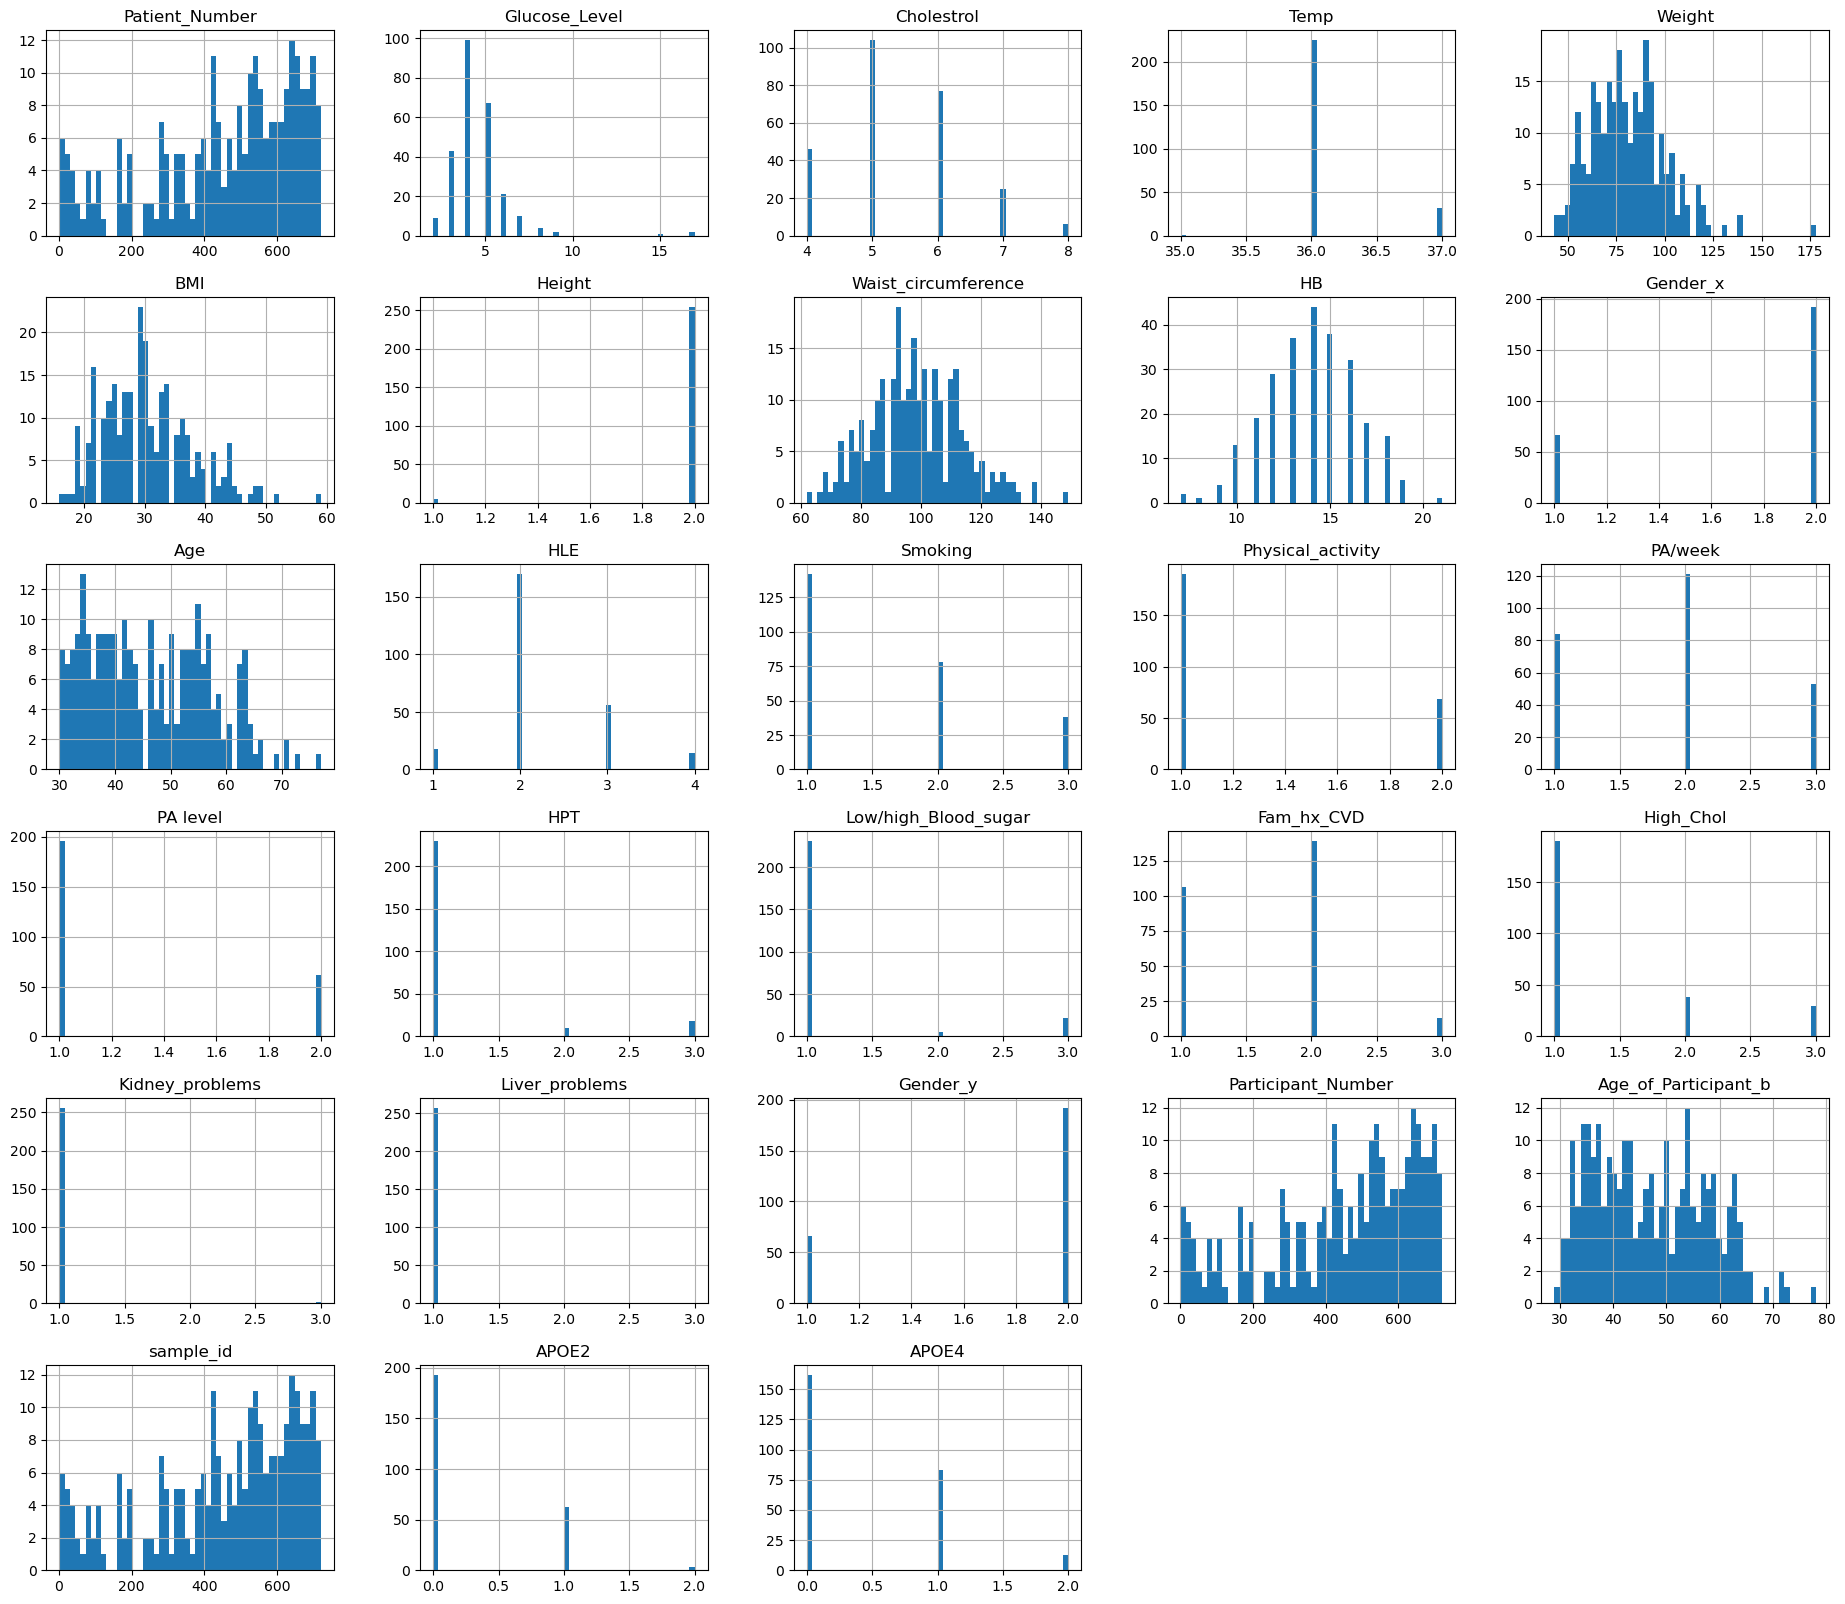

In [7]:
%matplotlib inline
vaccines.hist(bins=50, figsize=(23,20))
print("Histogram Plots")
plt.show()

In [8]:
print("Correlation Matrix")
quant_vaccines = vaccines.select_dtypes(include=[np.int64, np.float64])
corrMat = quant_vaccines.corr()
corrMat

Correlation Matrix


,Patient_Number,Glucose_Level,Cholestrol,Temp,Weight,BMI,Height,Waist_circumference,HB,Gender_x,Age,HLE,Smoking,Physical_activity,PA/week,PA level,HPT,Low/high_Blood_sugar,Fam_hx_CVD,High_Chol,Kidney_problems,Liver_problems,Gender_y,Participant_Number,Age_of_Participant_b,sample_id,APOE2,APOE4
Patient_Number,1.000e+00,2.153e-01,-0.163,-0.013,-0.054,-0.008,-1.321e-02,-2.412e-02,-4.313e-02,0.094,-0.024,-0.420,0.050,-0.125,-1.467e-01,7.485e-02,-0.044,-0.070,0.077,-0.284,-0.021,-0.020,0.094,1.000e+00,-0.094,1.000e+00,0.037,-4.512e-04
Glucose_Level,2.153e-01,1.000e+00,-0.039,0.052,0.126,0.166,-3.200e-02,1.326e-01,1.026e-01,0.055,0.060,-0.224,0.023,-0.026,3.925e-02,5.931e-04,0.061,0.043,0.041,-0.053,-0.002,0.016,0.055,2.153e-01,0.048,2.153e-01,0.139,-2.439e-02
Cholestrol,-1.632e-01,-3.873e-02,1.000,-0.023,-0.126,-0.079,-4.776e-02,-7.384e-02,7.573e-02,0.095,0.372,0.107,-0.089,0.054,8.346e-02,-6.400e-02,0.108,0.023,-0.128,0.067,0.057,0.105,0.095,-1.632e-01,0.388,-1.632e-01,-0.061,4.235e-02
Temp,-1.276e-02,5.214e-02,-0.023,1.000,0.006,-0.017,-4.837e-02,2.477e-03,1.262e-01,-0.055,-0.141,0.001,0.008,0.022,4.362e-02,-3.904e-02,0.053,0.103,0.003,0.037,0.100,0.163,-0.055,-1.276e-02,-0.142,-1.276e-02,0.020,1.770e-02
Weight,-5.360e-02,1.262e-01,-0.126,0.006,1.000,0.906,9.990e-02,8.727e-01,3.705e-02,0.007,-0.114,0.066,-0.043,0.116,-1.288e-02,-9.773e-02,0.097,-0.042,-0.110,-0.076,-0.046,-0.042,0.007,-5.360e-02,-0.106,-5.360e-02,0.057,-6.883e-02
BMI,-8.492e-03,1.663e-01,-0.079,-0.017,0.906,1.000,3.942e-03,8.735e-01,-1.231e-01,0.309,-0.013,-0.014,-0.084,0.096,-2.277e-03,-2.061e-01,0.092,-0.034,-0.138,-0.041,-0.012,-0.013,0.309,-8.492e-03,-0.011,-8.492e-03,0.083,-7.407e-02
Height,-1.321e-02,-3.200e-02,-0.048,-0.048,0.100,0.004,1.000e+00,1.283e-02,8.048e-04,-0.074,-0.096,0.096,0.060,0.004,6.632e-02,7.058e-02,0.042,0.042,0.085,0.024,0.011,0.008,-0.074,-1.321e-02,-0.096,-1.321e-02,0.004,-7.000e-02
Waist_circumference,-2.412e-02,1.326e-01,-0.074,0.002,0.873,0.874,1.283e-02,1.000e+00,-7.176e-03,0.132,0.010,-0.054,-0.034,0.123,2.774e-04,-1.927e-01,0.118,-0.022,-0.130,-0.073,-0.011,-0.005,0.132,-2.412e-02,0.015,-2.412e-02,0.036,-9.280e-02
HB,-4.313e-02,1.026e-01,0.076,0.126,0.037,-0.123,8.048e-04,-7.176e-03,1.000e+00,-0.389,-0.068,0.041,0.168,0.051,-3.389e-03,2.178e-01,0.142,0.088,0.065,0.074,-0.092,-0.052,-0.389,-4.313e-02,-0.060,-4.313e-02,-0.024,1.450e-02
Gender_x,9.392e-02,5.530e-02,0.095,-0.055,0.007,0.309,-7.358e-02,1.325e-01,-3.894e-01,1.000,0.112,-0.002,-0.153,-0.012,5.030e-02,-2.732e-01,-0.070,-0.070,-0.074,0.053,0.052,0.037,1.000,9.392e-02,0.102,9.392e-02,0.065,-4.715e-02


In [9]:
print("Categorical Variable Selection")
cat_vaccines = vaccines.select_dtypes(include=[object])
cat_vaccines.insert(0, 'Patient_Number', vaccines['Patient_Number']) 
    
cat_vaccines.head()

Categorical Variable Selection


,Patient_Number,Vaccine_Type,Vaccination_Status,Number_of_Doses,Boosting_Status,Side_Effects,Symptoms_and_Treatment,Hospitalization,Co-Morbidities,BP_Average,Weight_Category,Occupation,Marital_status,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,Symp_Cold_i,Symp_Cough_i,Symp_Sore_throat_i,Symp_Headache_i,breathlessness_i,taste_Smell_i,Close_to_Someonewith_Covid_i,break_through,raw_APOE2,raw_APOE4
0,1,Pfizer,complete,2 Doses + 1 Booster,boosted,Yes,Nil,No,Nil,High Normal,Normal,employed,3,Yes,2,N,N,N,N,N,N,N,N,N,N,N,N,N,NaN,N,N,CC,TT
1,2,Pfizer,complete,2 Doses + 1 Booster,boosted,No,Nil,No,Nil,High Normal,Normal,employed,4,No,2,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,N,CC,TT
2,8,Pfizer,complete,2 Doses,Not Boosted,No,Nil,No,Yes,High Normal,Obese,employed,3,No,2,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,CC,TT
3,9,Pfizer,complete,2 Doses,Not Boosted,No,Yes,Yes,Nil,Normal,Normal,employed,3,No,1,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,CT,TT
4,11,Pfizer,complete,2 Doses,Not Boosted,No,Nil,No,Nil,Normal,Obese,employed,1,No,2,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,CC,TT


##### Descriptions of the most relevant numeric features 

1. **HB**: Measures the hemoglobin levels in the blood. (Loading: 0.142)
2. **Smoking**: Categorizes individuals based on smoking habits. (Loading: 0.139)
3. **HPT**: Indicates the presence of Haptoglobin in the blood. (Loading: 0.138)
4. **High_Chol**: Indicates high cholesterol levels. (Loading: 0.134)
5. **PA level**: Indicates the intensity of physical activity. (Loading: 0.132)
6. **Glucose_Level**: Measures blood glucose levels. (Loading: 0.131)
7. **Gender_x**: Represents gender with categorical values. (Loading: 0.130)
8. **Gender_y**: Represents gender with categorical values. (Loading: 0.130)
9. **Physical_activity**: Indicates whether physical activity is undertaken. (Loading: 0.129)
10. **Low/high_Blood_sugar**: Indicates blood sugar levels. (Loading: 0.126)
11. **APOE4**: Presence of APOE4 allele. (Loading: 0.126)
12. **Cholestrol**: Total cholesterol level. (Loading: 0.124)
13. **APOE2**: Presence of APOE2 allele. (Loading: 0.123)
14. **Fam_hx_CVD**: Indicates family history of cardiovascular disease. (Loading: 0.122)
15. **Height**: Measure of the participant's height. (Loading: 0.119)
16. **HLE**: Categorizes education levels. (Loading: 0.117)
17. **Kidney_problems**: Indicates whether the participant has kidney problems. (Loading: 0.115)
18. **PA/week**: Indicates how often physical activity is performed. (Loading: 0.113)
19. **Temp**: Measures body temperature. (Loading: 0.110)
20. **Participant_Number**: Identifier for each participant. (Loading: 0.108)
21. **sample_id**: Identifier for each sample. (Loading: 0.108)
22. **Weight**: Measures the weight of the participant. (Loading: 0.103)
23. **Age_of_Participant_b**: Age of the participant. (Loading: 0.101)

#### Some notes so far

1. Possible new features for feature engineering:   

    **Augmented Features** 
    - Age_category - to see whether age categories can have an effect on clustering
    - Number_of_Doses - converting it to numerical form with string operations
    - Symptoms - combining symptoms count, higher value could be meaningful to clustering
    - Risk factor - combining risk factor count, higher value could be meaningful to clustering

    **Interaction Features** 
    - 'Weight_Glucose_Interaction' - helps us understand the combined effect of weight and glucose levels.
    - 'HPT_to_BloodSugar_Ratio' - helps us understand the combined effect of weight and glucose levels.    

2. Dimensionality Reduction (PCA):
   - We could have used PCA early on to determine the features that explain the variance in the dataset, but since this dataset was collected in relation to cardiovascular disease, PCA would be misleading. Unfortunately, we have to filter out the important columns by guided intuition.

# Phase 1
Data Preprocessing

This phase demonstrates the data preparation & feature extraction process

### Data Cleaning
Filtering dataset to include only participants vaccinated with Pfizer and J&J.

In [10]:
quant_vaccines.head()

,Patient_Number,Glucose_Level,Cholestrol,Temp,Weight,BMI,Height,Waist_circumference,HB,Gender_x,Age,HLE,Smoking,Physical_activity,PA/week,PA level,HPT,Low/high_Blood_sugar,Fam_hx_CVD,High_Chol,Kidney_problems,Liver_problems,Gender_y,Participant_Number,Age_of_Participant_b,sample_id,APOE2,APOE4
0,1,4,6,36,63,23,2,85,16,2,57,4,3,1,3,2,1,1,2,2,1,1,2,1,59,1,0,0
1,2,5,6,36,67,24,2,80,16,2,55,3,2,1,2,1,1,1,1,2,1,1,2,2,58,2,0,0
2,8,5,6,36,95,33,2,112,13,1,51,3,3,2,2,1,2,1,2,2,1,1,1,8,53,8,0,0
3,9,4,6,36,54,22,2,68,9,2,56,3,1,1,2,1,1,1,2,1,1,1,2,9,58,9,1,0
4,11,3,7,37,88,33,2,96,14,2,30,3,1,2,2,1,1,1,1,1,1,1,2,11,32,11,0,0


Now we select some quantitative features that could cause breakthrough infections by dropping the unrelated features.

By intuition, we only select feautres related to health status (blood pressure, glucose levels), potential impact on immune response (blood sugar levels), and general health metrics (weight), which could be relevant for understanding COVID-19 vaccination outcomes and breakthrough infections. 

We do this because the data was originally intended for cardiovascular disease

What we keep - ****['HPT', 'Glucose_Level', 'Low/high_Blood_sugar', 'Weight']****

HPT stands for Haptoglobin, a protein linked to immune response

In [11]:
quant_columns_to_drop = [
    'HB', 'Smoking', 'High_Chol', 'PA level', 
    'Gender_y', 'Physical_activity', 
    'APOE4', 'Cholestrol', 'APOE2', 'Fam_hx_CVD', 
    'Height', 'HLE', 'Kidney_problems', 'PA/week', 
    'Temp', 'Participant_Number', 'sample_id', 
    'Age_of_Participant_b'
]

quant_vaccines = quant_vaccines.drop(columns=quant_columns_to_drop)
quant_vaccines.head(10)

,Patient_Number,Glucose_Level,Weight,BMI,Waist_circumference,Gender_x,Age,HPT,Low/high_Blood_sugar,Liver_problems
0,1,4,63,23,85,2,57,1,1,1
1,2,5,67,24,80,2,55,1,1,1
2,8,5,95,33,112,1,51,2,1,1
3,9,4,54,22,68,2,56,1,1,1
4,11,3,88,33,96,2,30,1,1,1
5,12,4,88,36,114,2,31,1,1,1
6,17,5,122,49,137,2,48,1,1,1
7,18,3,85,29,98,1,37,1,1,1
8,21,3,78,30,94,2,56,1,1,1
9,23,4,91,33,106,2,40,1,1,1


Now we select some categorical features that could cause breakthrough infections by dropping the unrelated ones by intuition.

In [12]:
cat_vaccines.head(10)

,Patient_Number,Vaccine_Type,Vaccination_Status,Number_of_Doses,Boosting_Status,Side_Effects,Symptoms_and_Treatment,Hospitalization,Co-Morbidities,BP_Average,Weight_Category,Occupation,Marital_status,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,Symp_Cold_i,Symp_Cough_i,Symp_Sore_throat_i,Symp_Headache_i,breathlessness_i,taste_Smell_i,Close_to_Someonewith_Covid_i,break_through,raw_APOE2,raw_APOE4
0,1,Pfizer,complete,2 Doses + 1 Booster,boosted,Yes,Nil,No,Nil,High Normal,Normal,employed,3,Yes,2,N,N,N,N,N,N,N,N,N,N,N,N,N,NaN,N,N,CC,TT
1,2,Pfizer,complete,2 Doses + 1 Booster,boosted,No,Nil,No,Nil,High Normal,Normal,employed,4,No,2,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,N,CC,TT
2,8,Pfizer,complete,2 Doses,Not Boosted,No,Nil,No,Yes,High Normal,Obese,employed,3,No,2,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,CC,TT
3,9,Pfizer,complete,2 Doses,Not Boosted,No,Yes,Yes,Nil,Normal,Normal,employed,3,No,1,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,CT,TT
4,11,Pfizer,complete,2 Doses,Not Boosted,No,Nil,No,Nil,Normal,Obese,employed,1,No,2,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,CC,TT
5,12,Pfizer,complete,2 Doses(both Pfizer) + 1 Booster,boosted,Yes,Nil,No,Nil,High Normal,Obese,employed,2,No,2,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,CC,TC
6,17,Pfizer,complete,2 Doses,Not Boosted,No,Yes,No,Nil,High Normal,Obese,employed,3,No,2,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,CC,CC
7,18,NaN,incomplete,NaN,Not Boosted,NaN,NaN,NaN,NaN,Optimal,Overweight,employed,3,No,1,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,CC,TT
8,21,Pfizer,complete,3 Doses + Booster,boosted,Yes,Nil,No,Nil,High Normal,Obese,unemployed,1,No,2,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,CC,TT
9,23,Pfizer,incomplete,1 Dose + 1 Booster,boosted,Yes,Nil,No,Nil,High Normal,Obese,employed,1,No,2,N,N,N,N,N,N,N,NaN,N,N,N,N,N,N,N,Y,TT,TT


In [13]:
cat_columns_to_drop = [
    'Marital_status', 'raw_APOE4','Symp_Cold_i',
    'Symp_Cough_i','Symp_Sore_throat_i','Symp_Headache_i',
    'breathlessness_i','taste_Smell_i','Close_to_Someonewith_Covid_i',
    'Occupation', 'Symptoms_and_Treatment', 'Co-Morbidities'
]

selected_cat = cat_vaccines.drop(columns=cat_columns_to_drop)
selected_cat.head(10)

,Patient_Number,Vaccine_Type,Vaccination_Status,Number_of_Doses,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2
0,1,Pfizer,complete,2 Doses + 1 Booster,boosted,Yes,No,High Normal,Normal,Yes,2,N,N,N,N,N,N,N,N,N,CC
1,2,Pfizer,complete,2 Doses + 1 Booster,boosted,No,No,High Normal,Normal,No,2,N,N,N,N,N,NaN,N,N,N,CC
2,8,Pfizer,complete,2 Doses,Not Boosted,No,No,High Normal,Obese,No,2,N,N,N,N,N,N,N,Y,N,CC
3,9,Pfizer,complete,2 Doses,Not Boosted,No,Yes,Normal,Normal,No,1,N,N,N,N,N,N,N,N,N,CT
4,11,Pfizer,complete,2 Doses,Not Boosted,No,No,Normal,Obese,No,2,N,N,N,N,N,N,N,N,N,CC
5,12,Pfizer,complete,2 Doses(both Pfizer) + 1 Booster,boosted,Yes,No,High Normal,Obese,No,2,N,N,N,N,N,N,N,N,N,CC
6,17,Pfizer,complete,2 Doses,Not Boosted,No,No,High Normal,Obese,No,2,N,N,N,N,N,N,N,N,N,CC
7,18,NaN,incomplete,NaN,Not Boosted,NaN,NaN,Optimal,Overweight,No,1,N,N,N,N,N,N,N,N,N,CC
8,21,Pfizer,complete,3 Doses + Booster,boosted,Yes,No,High Normal,Obese,No,2,N,N,N,N,N,N,N,N,N,CC
9,23,Pfizer,incomplete,1 Dose + 1 Booster,boosted,Yes,No,High Normal,Obese,No,2,N,N,N,N,N,N,N,NaN,Y,TT


In [14]:
selected_cat.shape

(258, 21)

In [15]:
quant_vaccines.shape

(258, 10)

##### Merging quantitative and qualitative data

In [16]:
vacc = pd.merge(quant_vaccines, selected_cat, on='Patient_Number')
vacc.head()

,Patient_Number,Glucose_Level,Weight,BMI,Waist_circumference,Gender_x,Age,HPT,Low/high_Blood_sugar,Liver_problems,Vaccine_Type,Vaccination_Status,Number_of_Doses,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2
0,1,4,63,23,85,2,57,1,1,1,Pfizer,complete,2 Doses + 1 Booster,boosted,Yes,No,High Normal,Normal,Yes,2,N,N,N,N,N,N,N,N,N,CC
1,2,5,67,24,80,2,55,1,1,1,Pfizer,complete,2 Doses + 1 Booster,boosted,No,No,High Normal,Normal,No,2,N,N,N,N,N,NaN,N,N,N,CC
2,8,5,95,33,112,1,51,2,1,1,Pfizer,complete,2 Doses,Not Boosted,No,No,High Normal,Obese,No,2,N,N,N,N,N,N,N,Y,N,CC
3,9,4,54,22,68,2,56,1,1,1,Pfizer,complete,2 Doses,Not Boosted,No,Yes,Normal,Normal,No,1,N,N,N,N,N,N,N,N,N,CT
4,11,3,88,33,96,2,30,1,1,1,Pfizer,complete,2 Doses,Not Boosted,No,No,Normal,Obese,No,2,N,N,N,N,N,N,N,N,N,CC


In [17]:
vacc.shape

(260, 30)

Merging was successful and 2 extra rows were added but we will ignore. We got the expected column size of 15 

We can finally drop Patient_Number and proceed

In [18]:
vacc = vacc.drop(columns=['Patient_Number'])

##### Select participants vaccinated with Pfizer and J&J

In [19]:
vacc = vacc[(vacc['Vaccine_Type'] == 'Pfizer') | (vacc["Vaccine_Type"] == 'J&J') ]

##### Imputing missing values

Checking for missing values

In [20]:
vacc.isnull().sum()

Glucose_Level                  0
Weight                         0
BMI                            0
Waist_circumference            0
Gender_x                       0
Age                            0
HPT                            0
Low/high_Blood_sugar           0
Liver_problems                 0
Vaccine_Type                   0
Vaccination_Status             0
Number_of_Doses                0
Boosting_Status                0
Side_Effects                   0
Hospitalization                2
BP_Average                     0
Weight_Category                0
Hazardous exposure             0
Alcohol                        0
Symp_Cold                     33
Symp_Cough                    36
Symp_Sore_throat              33
Symp_Headache                 33
breathlessness                33
taste_Smell                   34
Close_to_Someonewith_Covid    33
COVID-19_comorbidities        34
break_through                  0
raw_APOE2                      0
dtype: int64

In [21]:
vacc.dtypes

Glucose_Level                  int64
Weight                         int64
BMI                            int64
Waist_circumference            int64
Gender_x                       int64
Age                            int64
HPT                            int64
Low/high_Blood_sugar           int64
Liver_problems                 int64
Vaccine_Type                  object
Vaccination_Status            object
Number_of_Doses               object
Boosting_Status               object
Side_Effects                  object
Hospitalization               object
BP_Average                    object
Weight_Category               object
Hazardous exposure            object
Alcohol                       object
Symp_Cold                     object
Symp_Cough                    object
Symp_Sore_throat              object
Symp_Headache                 object
breathlessness                object
taste_Smell                   object
Close_to_Someonewith_Covid    object
COVID-19_comorbidities        object
b

In [22]:
vacc.head()

,Glucose_Level,Weight,BMI,Waist_circumference,Gender_x,Age,HPT,Low/high_Blood_sugar,Liver_problems,Vaccine_Type,Vaccination_Status,Number_of_Doses,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2
0,4,63,23,85,2,57,1,1,1,Pfizer,complete,2 Doses + 1 Booster,boosted,Yes,No,High Normal,Normal,Yes,2,N,N,N,N,N,N,N,N,N,CC
1,5,67,24,80,2,55,1,1,1,Pfizer,complete,2 Doses + 1 Booster,boosted,No,No,High Normal,Normal,No,2,N,N,N,N,N,NaN,N,N,N,CC
2,5,95,33,112,1,51,2,1,1,Pfizer,complete,2 Doses,Not Boosted,No,No,High Normal,Obese,No,2,N,N,N,N,N,N,N,Y,N,CC
3,4,54,22,68,2,56,1,1,1,Pfizer,complete,2 Doses,Not Boosted,No,Yes,Normal,Normal,No,1,N,N,N,N,N,N,N,N,N,CT
4,3,88,33,96,2,30,1,1,1,Pfizer,complete,2 Doses,Not Boosted,No,No,Normal,Obese,No,2,N,N,N,N,N,N,N,N,N,CC


The int64 columns actually have no null values upon inspection. 

Also, we can impute the Hospitalization values manually, however, the result for vacc.isnull().sum() above is innacurate because in vacc.head() we see diguised null values like Nil. We would have to take care of these.

In [23]:
null_values = ['nil', 'Nil', 'NA', 'None', '']

vacc.replace(null_values, np.nan, inplace=True)

In [24]:
vacc.shape

(157, 29)

Finally we drop na values from Hospitalization

In [25]:
print(f"Shape before dropna {vacc.shape}")
vacc.dropna(axis=0, inplace=True)
print(f"Shape after dropna {vacc.shape}")

Shape before dropna (157, 29)
Shape after dropna (117, 29)


#### Removing redundant features
We will only drop duplicates here since redundant features were already taken care off earlier in this phase

In [26]:
print(f"Duplicated Rows in X with shape {vacc.shape}:")
vacc[vacc.duplicated(keep=False)]

Duplicated Rows in X with shape (117, 29):


,Glucose_Level,Weight,BMI,Waist_circumference,Gender_x,Age,HPT,Low/high_Blood_sugar,Liver_problems,Vaccine_Type,Vaccination_Status,Number_of_Doses,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2
104,3,93,27,96,1,32,1,1,1,Pfizer,complete,2 Doses + 1 Booster,boosted,No,No,High Normal,Overweight,No,2,N,N,N,N,N,N,N,N,N,CC
106,3,93,27,96,1,32,1,1,1,Pfizer,complete,2 Doses + 1 Booster,boosted,No,No,High Normal,Overweight,No,2,N,N,N,N,N,N,N,N,N,CC


In [27]:
vacc = vacc.drop_duplicates()
print(f"New shape after dropping duplicates: {vacc.shape}")

New shape after dropping duplicates: (116, 29)


# Phase 2
Feature Engineering

### Feature Engineering
Create feature subsets that gear towards the goal of how understanding COVID-19 vaccination outcomes affect breakthrough infections

This is feature engineering for mostly numeric data which are the variables we can manipulate best currently. The remaining augmented features Symptoms and Risk Factor will be engineered after encoding since they will also become numeric.

In [28]:
#Interaction Features
vacc['Weight_Glucose_Interaction'] = vacc['Weight'] * vacc['Glucose_Level']
#Ratio Features
vacc['HPT_to_BloodSugar_Ratio'] = vacc['HPT'] / vacc['Low/high_Blood_sugar']
#Augmented Features
vacc['Age_Category'] = pd.cut(quant_vaccines['Age'], bins=[0, 18, 35, 50, np.inf], labels=['<18', '18-35', '36-50', '50+'])
vacc['Number_of_Doses'] = pd.to_numeric(vacc['Number_of_Doses'].str.split().str[0], errors='coerce')

In [29]:
vacc.dropna(axis=0, inplace=True)

In [30]:
vacc.head(5)

,Glucose_Level,Weight,BMI,Waist_circumference,Gender_x,Age,HPT,Low/high_Blood_sugar,Liver_problems,Vaccine_Type,Vaccination_Status,Number_of_Doses,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2,Weight_Glucose_Interaction,HPT_to_BloodSugar_Ratio,Age_Category
0,4,63,23,85,2,57,1,1,1,Pfizer,complete,2,boosted,Yes,No,High Normal,Normal,Yes,2,N,N,N,N,N,N,N,N,N,CC,252,1.0,50+
2,5,95,33,112,1,51,2,1,1,Pfizer,complete,2,Not Boosted,No,No,High Normal,Obese,No,2,N,N,N,N,N,N,N,Y,N,CC,475,2.0,50+
3,4,54,22,68,2,56,1,1,1,Pfizer,complete,2,Not Boosted,No,Yes,Normal,Normal,No,1,N,N,N,N,N,N,N,N,N,CT,216,1.0,50+
4,3,88,33,96,2,30,1,1,1,Pfizer,complete,2,Not Boosted,No,No,Normal,Obese,No,2,N,N,N,N,N,N,N,N,N,CC,264,1.0,18-35
5,4,88,36,114,2,31,1,1,1,Pfizer,complete,2,boosted,Yes,No,High Normal,Obese,No,2,N,N,N,N,N,N,N,N,N,CC,352,1.0,18-35


### Feature Encoding

Some simple mapping encoding

In [31]:
alcohol_mapping = {1: 'Yes', 2: 'No', 'Occasionally 3mnths': 'Occasionally'}
gender_mapping = {1: 'Male', 2: 'Female'}


vacc['Alcohol'] = vacc['Alcohol'].map(alcohol_mapping)
vacc['Gender_x'] = vacc['Gender_x'].map(gender_mapping)

In [32]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X

In [33]:
# Define your pipelines
quantPipe = Pipeline([
    ("identity", IdentityTransformer()),  # does nothing but is needed to preserved data shape
])

catPipe = Pipeline([
    ("encode", OrdinalEncoder()),
])

fullPipe2 = ColumnTransformer([
    ("quant", quantPipe, make_column_selector(dtype_exclude=["object", "category"])),  
    ("cat", catPipe, make_column_selector(dtype_include=["object", "category"])),
])

##### Reorder DataFrame columns to pass them cleanly into the pipeline

In [34]:
sorted_columns = (vacc.select_dtypes(include=['int64', 'float64'])  # Numerical columns
                  .columns.tolist() +
                  vacc.select_dtypes(include=['object', 'category'])  # Categorical columns
                  .columns.tolist())

vacc = vacc[sorted_columns]

In [35]:
vacc.dtypes

Glucose_Level                    int64
Weight                           int64
BMI                              int64
Waist_circumference              int64
Age                              int64
HPT                              int64
Low/high_Blood_sugar             int64
Liver_problems                   int64
Number_of_Doses                  int64
Weight_Glucose_Interaction       int64
HPT_to_BloodSugar_Ratio        float64
Gender_x                        object
Vaccine_Type                    object
Vaccination_Status              object
Boosting_Status                 object
Side_Effects                    object
Hospitalization                 object
BP_Average                      object
Weight_Category                 object
Hazardous exposure              object
Alcohol                         object
Symp_Cold                       object
Symp_Cough                      object
Symp_Sore_throat                object
Symp_Headache                   object
breathlessness           

In [36]:
X_transformed = fullPipe2.fit_transform(vacc)

In [37]:
vacc['Alcohol'].value_counts()

Alcohol
Yes             68
No              47
Occasionally     1
Name: count, dtype: int64

In [38]:
vacc.head()

,Glucose_Level,Weight,BMI,Waist_circumference,Age,HPT,Low/high_Blood_sugar,Liver_problems,Number_of_Doses,Weight_Glucose_Interaction,HPT_to_BloodSugar_Ratio,Gender_x,Vaccine_Type,Vaccination_Status,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2,Age_Category
0,4,63,23,85,57,1,1,1,2,252,1.0,Female,Pfizer,complete,boosted,Yes,No,High Normal,Normal,Yes,No,N,N,N,N,N,N,N,N,N,CC,50+
2,5,95,33,112,51,2,1,1,2,475,2.0,Male,Pfizer,complete,Not Boosted,No,No,High Normal,Obese,No,No,N,N,N,N,N,N,N,Y,N,CC,50+
3,4,54,22,68,56,1,1,1,2,216,1.0,Female,Pfizer,complete,Not Boosted,No,Yes,Normal,Normal,No,Yes,N,N,N,N,N,N,N,N,N,CT,50+
4,3,88,33,96,30,1,1,1,2,264,1.0,Female,Pfizer,complete,Not Boosted,No,No,Normal,Obese,No,No,N,N,N,N,N,N,N,N,N,CC,18-35
5,4,88,36,114,31,1,1,1,2,352,1.0,Female,Pfizer,complete,boosted,Yes,No,High Normal,Obese,No,No,N,N,N,N,N,N,N,N,N,CC,18-35


In [39]:
X = pd.DataFrame(X_transformed, columns=vacc.columns)
X.head(10)

,Glucose_Level,Weight,BMI,Waist_circumference,Age,HPT,Low/high_Blood_sugar,Liver_problems,Number_of_Doses,Weight_Glucose_Interaction,HPT_to_BloodSugar_Ratio,Gender_x,Vaccine_Type,Vaccination_Status,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2,Age_Category
0,4.0,63.0,23.0,85.0,57.0,1.0,1.0,1.0,2.0,252.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,5.0,95.0,33.0,112.0,51.0,2.0,1.0,1.0,2.0,475.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
2,4.0,54.0,22.0,68.0,56.0,1.0,1.0,1.0,2.0,216.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,3.0,88.0,33.0,96.0,30.0,1.0,1.0,1.0,2.0,264.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,88.0,36.0,114.0,31.0,1.0,1.0,1.0,2.0,352.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.0,122.0,49.0,137.0,48.0,1.0,1.0,1.0,2.0,610.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,3.0,78.0,30.0,94.0,56.0,1.0,1.0,1.0,3.0,234.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
7,4.0,88.0,27.0,96.0,40.0,1.0,1.0,1.0,1.0,352.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,4.0,65.0,22.0,87.0,59.0,1.0,1.0,1.0,2.0,260.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,4.0,57.0,27.0,87.0,57.0,1.0,1.0,1.0,2.0,228.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [40]:
X.dropna(axis=0, inplace=True)

In [41]:
vacc.head(10)

,Glucose_Level,Weight,BMI,Waist_circumference,Age,HPT,Low/high_Blood_sugar,Liver_problems,Number_of_Doses,Weight_Glucose_Interaction,HPT_to_BloodSugar_Ratio,Gender_x,Vaccine_Type,Vaccination_Status,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2,Age_Category
0,4,63,23,85,57,1,1,1,2,252,1.0,Female,Pfizer,complete,boosted,Yes,No,High Normal,Normal,Yes,No,N,N,N,N,N,N,N,N,N,CC,50+
2,5,95,33,112,51,2,1,1,2,475,2.0,Male,Pfizer,complete,Not Boosted,No,No,High Normal,Obese,No,No,N,N,N,N,N,N,N,Y,N,CC,50+
3,4,54,22,68,56,1,1,1,2,216,1.0,Female,Pfizer,complete,Not Boosted,No,Yes,Normal,Normal,No,Yes,N,N,N,N,N,N,N,N,N,CT,50+
4,3,88,33,96,30,1,1,1,2,264,1.0,Female,Pfizer,complete,Not Boosted,No,No,Normal,Obese,No,No,N,N,N,N,N,N,N,N,N,CC,18-35
5,4,88,36,114,31,1,1,1,2,352,1.0,Female,Pfizer,complete,boosted,Yes,No,High Normal,Obese,No,No,N,N,N,N,N,N,N,N,N,CC,18-35
6,5,122,49,137,48,1,1,1,2,610,1.0,Female,Pfizer,complete,Not Boosted,No,No,High Normal,Obese,No,No,N,N,N,N,N,N,N,N,N,CC,36-50
8,3,78,30,94,56,1,1,1,3,234,1.0,Female,Pfizer,complete,boosted,Yes,No,High Normal,Obese,No,No,N,N,N,N,N,N,N,N,N,CC,50+
11,4,88,27,96,40,1,1,1,1,352,1.0,Male,J&J,complete,boosted,No,No,Normal,Overweight,Yes,Yes,N,N,N,N,N,N,N,N,N,CC,36-50
12,4,65,22,87,59,1,1,1,2,260,1.0,Male,Pfizer,complete,Not Boosted,No,No,Normal,Normal,No,No,N,N,N,N,N,N,N,N,N,CC,50+
13,4,57,27,87,57,1,1,1,2,228,1.0,Female,Pfizer,complete,Not Boosted,No,No,Normal,Overweight,No,No,N,N,N,N,N,N,N,N,N,CC,50+


Combine all symptoms into a single feature. Higher sum indicates more symptom count.

In [42]:
symptoms_columns = ['Symp_Cold', 'Symp_Cough', 'Symp_Sore_throat', 'Symp_Headache', 'breathlessness', 'taste_Smell']
X['Symptoms'] = X[symptoms_columns].sum(axis=1)

Combine risk factors into a single feature

In [43]:
risk_factor_columns = ['COVID-19_comorbidities', 'Boosting_Status', 'Vaccination_Status', 
                       'Close_to_Someonewith_Covid', 'Hazardous exposure']

covid_comorbidities_mapping = {1.0: 1.0, 0.0: 0.0}
boosting_status_mapping = {1.0: 1.0, 0.0: 0.0}
vaccination_status_mapping = {1.0: 1.0, 0.0: 0.0}
close_to_covid_mapping = {1.0: 1.0, 0.0: 0.0}
hazardous_exposure_mapping = {1.0: 1.0, 0.0: 0.0}

Xtemp = X[risk_factor_columns].copy() #taking only needed columns for risk factor scoring

Xtemp['COVID-19_comorbidities'] = Xtemp['COVID-19_comorbidities'].map(covid_comorbidities_mapping)
Xtemp['Boosting_Status'] = Xtemp['Boosting_Status'].map(covid_comorbidities_mapping)
Xtemp['Vaccination_Status'] = Xtemp['Vaccination_Status'].map(vaccination_status_mapping)
Xtemp['Close_to_Someonewith_Covid'] = Xtemp['Close_to_Someonewith_Covid'].map(close_to_covid_mapping)
Xtemp['Hazardous exposure'] = Xtemp['Hazardous exposure'].map(hazardous_exposure_mapping)

# Assigning the calculated risk factor scores back to X from Xtemp
X['Risk_Factor'] = Xtemp.sum(axis=1)

In [44]:
X.dtypes

Glucose_Level                 float64
Weight                        float64
BMI                           float64
Waist_circumference           float64
Age                           float64
HPT                           float64
Low/high_Blood_sugar          float64
Liver_problems                float64
Number_of_Doses               float64
Weight_Glucose_Interaction    float64
HPT_to_BloodSugar_Ratio       float64
Gender_x                      float64
Vaccine_Type                  float64
Vaccination_Status            float64
Boosting_Status               float64
Side_Effects                  float64
Hospitalization               float64
BP_Average                    float64
Weight_Category               float64
Hazardous exposure            float64
Alcohol                       float64
Symp_Cold                     float64
Symp_Cough                    float64
Symp_Sore_throat              float64
Symp_Headache                 float64
breathlessness                float64
taste_Smell 

In [45]:
X.head()

,Glucose_Level,Weight,BMI,Waist_circumference,Age,HPT,Low/high_Blood_sugar,Liver_problems,Number_of_Doses,Weight_Glucose_Interaction,HPT_to_BloodSugar_Ratio,Gender_x,Vaccine_Type,Vaccination_Status,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2,Age_Category,Symptoms,Risk_Factor
0,4.0,63.0,23.0,85.0,57.0,1.0,1.0,1.0,2.0,252.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0
1,5.0,95.0,33.0,112.0,51.0,2.0,1.0,1.0,2.0,475.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
2,4.0,54.0,22.0,68.0,56.0,1.0,1.0,1.0,2.0,216.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0
3,3.0,88.0,33.0,96.0,30.0,1.0,1.0,1.0,2.0,264.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.0,88.0,36.0,114.0,31.0,1.0,1.0,1.0,2.0,352.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [46]:
X.shape

(116, 34)

Drom the individual symptoms and risk factors since we have the augmented versions.
Afterwards proceed to train.

In [47]:
X2 = X.drop(risk_factor_columns, axis=1)
X2.shape

(116, 29)

In [48]:
X2 = X.drop(symptoms_columns, axis=1)
X2.shape

(116, 28)

In [49]:
X2.head()

,Glucose_Level,Weight,BMI,Waist_circumference,Age,HPT,Low/high_Blood_sugar,Liver_problems,Number_of_Doses,Weight_Glucose_Interaction,HPT_to_BloodSugar_Ratio,Gender_x,Vaccine_Type,Vaccination_Status,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2,Age_Category,Symptoms,Risk_Factor
0,4.0,63.0,23.0,85.0,57.0,1.0,1.0,1.0,2.0,252.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0
1,5.0,95.0,33.0,112.0,51.0,2.0,1.0,1.0,2.0,475.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
2,4.0,54.0,22.0,68.0,56.0,1.0,1.0,1.0,2.0,216.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0
3,3.0,88.0,33.0,96.0,30.0,1.0,1.0,1.0,2.0,264.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.0,88.0,36.0,114.0,31.0,1.0,1.0,1.0,2.0,352.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [50]:
X2.shape

(116, 28)

In [51]:
vacc.shape

(116, 32)

## Phase 3
Clustering

### Determining Optimal K
Using the elbow method and then verifying with Knee Locator and Silhoutte Score

#### Elbow Method
Uses change in gradient of intraclass variances ie. inertia for different values of k to determine an optimal k.
For the optimal k, the gradient of the next k will have a drastic decline in gradient, creating the elbow shape.

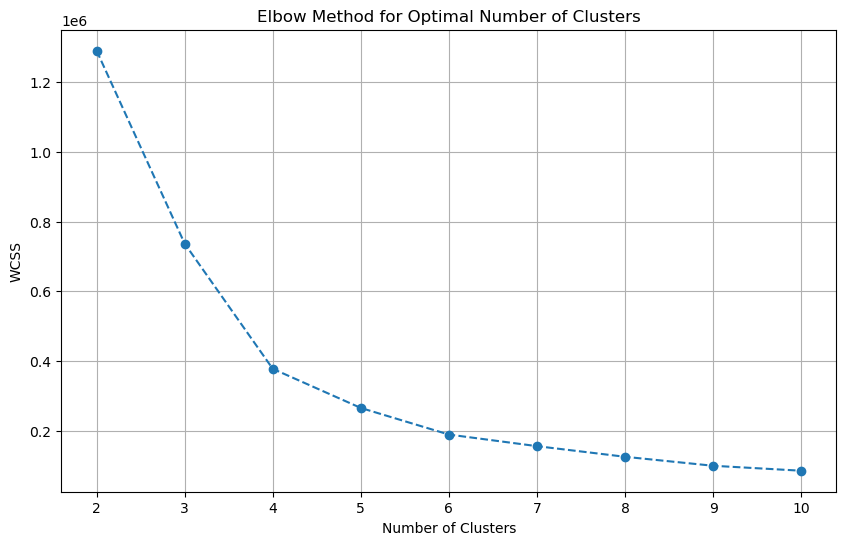

In [52]:
wcss = []
sil_scores = []
calinski_scores = []

for k in range(2, 11):  # Testing from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=8) 
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Within-Cluster Sum of Squares aka inertia
    sil_scores.append(silhouette_score(X, kmeans.labels_))
    calinski_scores.append(calinski_harabasz_score(X, kmeans.labels_))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

##### Based on the plot, we select optimal number of clusters k=4

In [53]:
optimal_k = 4

#### Silhoutte Score Method
Uses the change in both intraclass and interclass variances for different values of k to determinal optimal k. The optimal k will be at the peak of the graph ie. will have the highest silhoutte score. It helps prevent overfitting because inertias always decrease as k increases but silhoutte scores increase and then decrease after the optimal k.

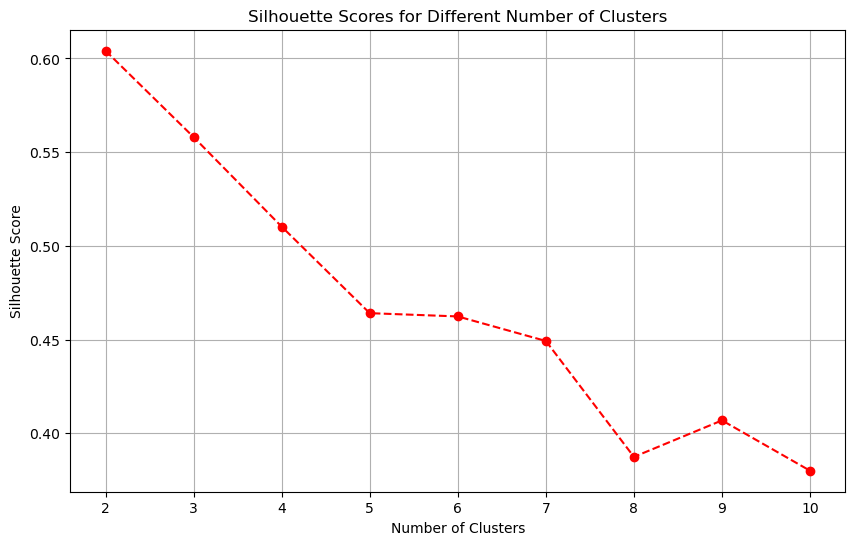

In [54]:
k_range = range(2, 11)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, sil_scores, marker='o', linestyle='--', color='r')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.grid(True)

plt.show()

In [55]:
# Use KneeLocator to find the optimal number of clusters
knee_locator = KneeLocator(range(2, 11), wcss, curve='convex', direction='decreasing')
optimal_k = knee_locator.elbow
print(f"The knee locator gives returns an elbow (optimal k) of {optimal_k}")

The knee locator gives returns an elbow (optimal k) of 4


### K-means Clustering 
Using the optimal K

In [56]:
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=100, n_init=10, random_state=8)
kmeans.fit(X)

# Evaluate the K-means model
silhouette = silhouette_score(X, kmeans.labels_)
calinski = calinski_harabasz_score(X, kmeans.labels_)
wcss = kmeans.inertia_

print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Score: {calinski}")
print(f"Within-Cluster Sum of Squares: {wcss}")

Silhouette Score: 0.5102416515882212
Calinski-Harabasz Score: 247.5841858846701
Within-Cluster Sum of Squares: 378037.7196791468


We will store the cluster labels from the K-means model so we can pass them onto therandom forest classifer later on in this phase.

In [57]:
cluster_labels = pd.DataFrame({'cluster_label': kmeans.labels_})
cluster_labels = cluster_labels.values.ravel()

##### Visualizing the clusters (2D plot using PCA for dimensionality reduction)

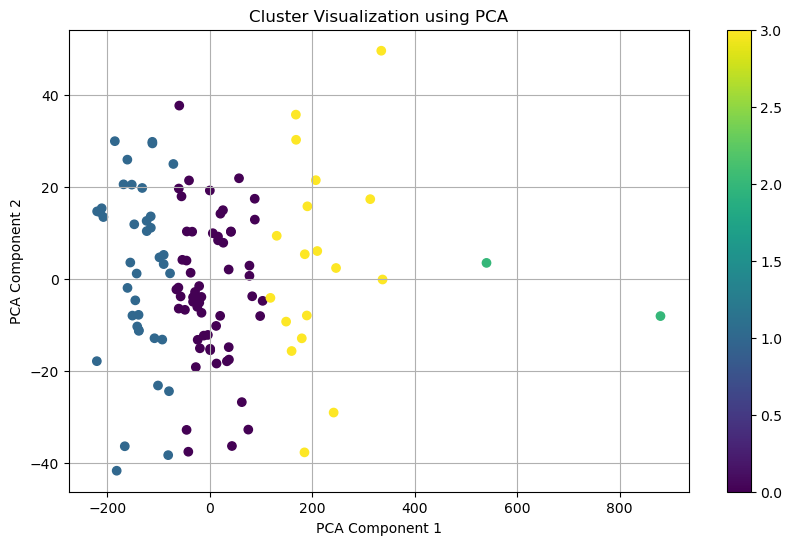

In [58]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('Cluster Visualization using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.colorbar()
plt.show()

### Changing optimal k to 3

**Important step**  
The visualization looks interesting. It seems there is a cluster that has just 2 people, so we can move them manually to the closest cluster (yellow).

In [59]:
X2.insert(0, 'cluster_label', cluster_labels) 

We insert cluster labels back into dataset to check value counts. 

It will also to enable visualization in Phase 5.

In [60]:
X2['cluster_label'].value_counts()

cluster_label
0    58
1    38
3    18
2     2
Name: count, dtype: int64

So we move the two points in cluster label 2 to cluster label 3.

In [61]:
cluster_mapping1 = {0:0,1:1,2:3, 3:3}
X2['cluster_label'] = X2['cluster_label'].map(cluster_mapping1)

Change it to range from 0 to 2 (3 clusters)

In [62]:
cluster_mapping2 = {0:0,1:1,3:2}
X2['cluster_label'] = X2['cluster_label'].map(cluster_mapping2)

We now verify the counts after modification. It should be 20 (18+2)

In [63]:
X2['cluster_label'].value_counts()

cluster_label
0    58
1    38
2    20
Name: count, dtype: int64

Change optimal k to 3

In [64]:
optimal_k = 3

### Training Random Forest Classifier

In [65]:
rf = RandomForestClassifier(n_estimators=100, random_state=8, n_jobs=-1)
rf.fit(X, cluster_labels)

RandomForestClassifier(n_jobs=-1, random_state=8)

In [66]:
cluster_labels.shape

(116,)

In [67]:
X.shape

(116, 34)

# Phase 4
Explainability with SHAP

### Applying SHAP
SHAP is utilized here to determine feature importance for the Random Forest model

PermutationExplainer explainer: 117it [00:10,  3.42s/it]                        


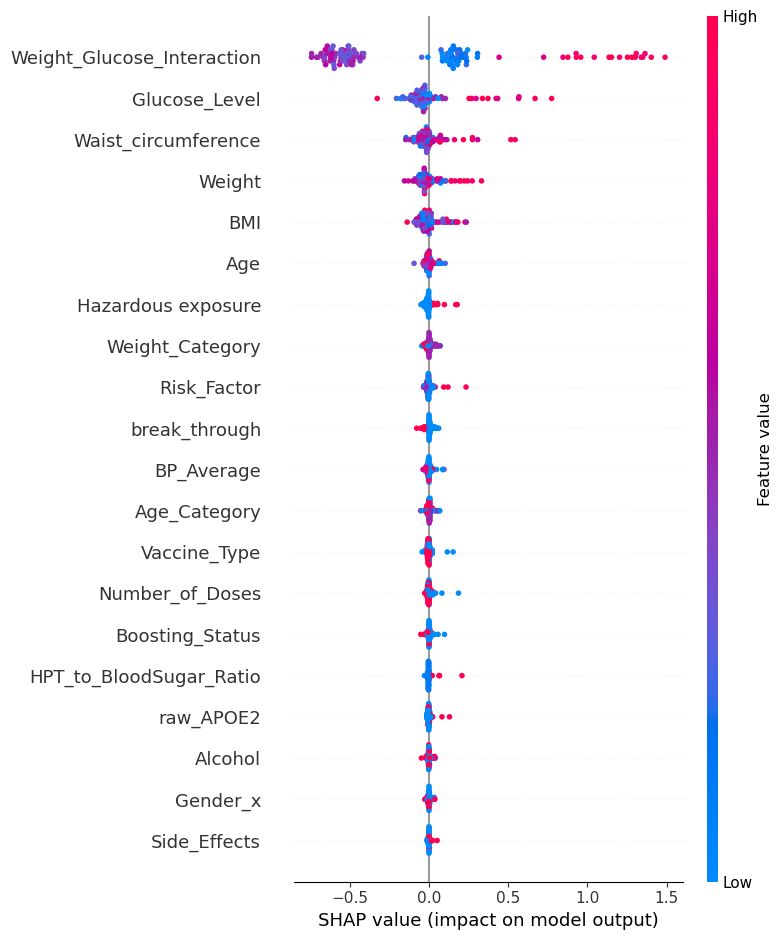

In [68]:
explainer = shap.Explainer(rf.predict, X)

shap_values = explainer(X)

shap.summary_plot(shap_values, X,feature_names=X.columns)

In [69]:
top7_quant_features = ['Weight_Glucose_Interaction','Glucose_Level','Weight',
                 'BMI','Waist_circumference','Age','Risk_Factor']

top7_quant_features_array = np.array(top7_quant_features)

In [70]:
X.head()

,Glucose_Level,Weight,BMI,Waist_circumference,Age,HPT,Low/high_Blood_sugar,Liver_problems,Number_of_Doses,Weight_Glucose_Interaction,HPT_to_BloodSugar_Ratio,Gender_x,Vaccine_Type,Vaccination_Status,Boosting_Status,Side_Effects,Hospitalization,BP_Average,Weight_Category,Hazardous exposure,Alcohol,Symp_Cold,Symp_Cough,Symp_Sore_throat,Symp_Headache,breathlessness,taste_Smell,Close_to_Someonewith_Covid,COVID-19_comorbidities,break_through,raw_APOE2,Age_Category,Symptoms,Risk_Factor
0,4.0,63.0,23.0,85.0,57.0,1.0,1.0,1.0,2.0,252.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0
1,5.0,95.0,33.0,112.0,51.0,2.0,1.0,1.0,2.0,475.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
2,4.0,54.0,22.0,68.0,56.0,1.0,1.0,1.0,2.0,216.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0
3,3.0,88.0,33.0,96.0,30.0,1.0,1.0,1.0,2.0,264.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.0,88.0,36.0,114.0,31.0,1.0,1.0,1.0,2.0,352.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


## Phase 5
Results & Visualization

### Cluster Analysis

We can decode some useful features in our transformed dataset to make analyis easier.

In [71]:
#Define mapping dictionaries for decoding
vaccine_mapping = {1.0: 'Pfizer', 0.0: 'J&J'}
break_through_mapping = {0.0: 'No', 1.0: 'Yes'}
covid_comorbidities_mapping = {0.0: 'No', 1.0: 'Yes'}
close_to_covid_mapping = {0.0: 'No', 1.0: 'Yes'}
hazardous_exposure_mapping = {0.0: 'No', 1.0: 'Yes'}
bp_average_mapping = {0.0: 'High Normal', 3.0: 'Normal', 1.0: 'Mild_Hypertension', 4.0: 'Optimal', 2.0: 'Moderate_Hypertension', 5.0: 'Severe_Hypertension'}
age_category_mapping = {2.0: '50+', 0.0: '18-35', 1.0: '36-50'}
weight_category_mapping = {0.0: 'Normal',1.0:'Obese',2.0:'Overweight'}
hosptialization_mapping = {0.0: 'No', 1.0: 'Yes'}
side_effects_mapping = {0.0: 'No', 1.0: 'Yes'}
boosting_status = {0.0: 'boosted', 1.0: 'Not Boosted'}
vaccination_status = {0.0: 'complete', 1.0: 'incomplete'}
alcohol_cat_mapping = {2.0: 'Yes', 0.0: 'No', 1.0: 'Occasionally'}
raw_APOE2_mapping = {0.0: 'CC', 1.0: 'CT',2.0:'TT'}
gender_cat_mapping = {1.0: 'Male', 0.0: 'Female'}

#Safekeep X3
X3 = X2.copy()

#Apply mapping to decode numerical values to strings
X3['Vaccine_Type'] = X3['Vaccine_Type'].map(vaccine_mapping)
X3['break_through'] = X3['break_through'].map(break_through_mapping)
X3['COVID-19_comorbidities'] = X3['COVID-19_comorbidities'].map(covid_comorbidities_mapping)
X3['Close_to_Someonewith_Covid'] = X3['Close_to_Someonewith_Covid'].map(close_to_covid_mapping)
X3['Hazardous exposure'] = X3['Hazardous exposure'].map(hazardous_exposure_mapping)
X3['BP_Average'] = X3['BP_Average'].map(bp_average_mapping)
X3['Age_Category'] = X3['Age_Category'].map(age_category_mapping)
X3['Weight_Category'] = X3['Weight_Category'].map(weight_category_mapping)
X3['Hospitalization'] = X3['Hospitalization'].map(hosptialization_mapping)
X3['Side_Effects'] = X3['Side_Effects'].map(side_effects_mapping)
X3['Boosting_Status'] = X3['Boosting_Status'].map(boosting_status)
X3['Vaccination_Status'] = X3['Vaccination_Status'].map(vaccination_status)
X3['Alcohol'] = X3['Alcohol'].map(alcohol_cat_mapping)
X3['raw_APOE2'] = X3['raw_APOE2'].map(raw_APOE2_mapping)
X3['Gender_x'] = X3['Gender_x'].map(gender_cat_mapping)

### Results - Tables - Quantitative Visualization

#### 1. Distribution of Vaccines in each cluster

We also have to reset the cluster labels before proceeding.
2s are mapped to 3 then all 3 mapped back to 2.
Now cluster_labels (a numpy array) and X3['cluster_labels'] match

In [72]:
cluster_labels_mapped = np.array([cluster_mapping1[label] for label in cluster_labels])
cluster_labels_mapped = np.array([cluster_mapping2[label] for label in cluster_labels_mapped])
cluster_labels=cluster_labels_mapped

In [73]:
vacc_distr = pd.DataFrame()
vacc_distr['Cluster'] = range(1,optimal_k+1)
vacc_distr['Pfizer'] = [sum((cluster_labels == i) & (X3['Vaccine_Type'] == 'Pfizer')) for i in range(optimal_k)]
vacc_distr['J&J'] = [sum((cluster_labels == i) & (X3['Vaccine_Type'] == 'J&J')) for i in range(optimal_k)]

In [74]:
display(Markdown("**Table 1**: Distribution of Vaccines in each cluster"))
vacc_distr

**Table 1**: Distribution of Vaccines in each cluster

,Cluster,Pfizer,J&J
0,1,43,15
1,2,32,6
2,3,12,8


#### 2.  Clusters in relation to Breakthrough Infection

In [75]:
vaccinated_counts = [sum(cluster_labels == i) for i in range(optimal_k)]

breakthrough_distribution = pd.DataFrame()
breakthrough_distribution['Cluster'] = range(1, optimal_k + 1)
breakthrough_distribution['Number Vaccinated'] = vaccinated_counts
breakthrough_distribution['BKI Yes'] = [sum((cluster_labels == i) & (X3['break_through'] == 'Yes')) 
                                        for i in range(optimal_k)]
breakthrough_distribution['BKI No'] = [sum((cluster_labels == i) & (X3['break_through'] == 'No')) 
                                       for i in range(optimal_k)]

In [76]:
display(Markdown("**Table 2**: Clusters in relation to Breakthrough Infection"))
breakthrough_distribution

**Table 2**: Clusters in relation to Breakthrough Infection

,Cluster,Number Vaccinated,BKI Yes,BKI No
0,1,58,21,37
1,2,38,7,31
2,3,20,3,17


#### 3. Clusters in relation to Breakthrough Infection Percentages (%) per Vaccine

In [77]:
#Calculate the total number of individuals in each cluster
cluster_totals = pd.Series(cluster_labels).value_counts().sort_index()

#Calculate the number of vaccinated individuals for each vaccine type in each cluster
vaccinated_counts = pd.DataFrame({
    'Cluster': range(1, optimal_k + 1),
    'Pfizer': [sum((cluster_labels == i) & (X3['Vaccine_Type'] == 'Pfizer')) for i in range(optimal_k)],
    'J&J': [sum((cluster_labels == i) & (X3['Vaccine_Type'] == 'J&J')) for i in range(optimal_k)]
})

#Calculate the number of breakthrough infections for each vaccine type in each cluster
bki_counts = pd.DataFrame({
    'Cluster': range(1, optimal_k + 1),
    'Pfizer': [sum((cluster_labels == i) & (X3['Vaccine_Type'] == 'Pfizer') & (X3['break_through'] == 'Yes')) 
               for i in range(optimal_k)],
    'J&J': [sum((cluster_labels == i) & (X3['Vaccine_Type'] == 'J&J') & (X3['break_through'] == 'Yes')) 
            for i in range(optimal_k)]
})

#Calculate the breakthrough infection percentages
bki_percentages = pd.DataFrame({
    'Cluster': range(1, optimal_k + 1),
    'Pfizer_BKI (%)': [bki_counts['Pfizer'][i] / vaccinated_counts['Pfizer'][i] * 100 
                       if vaccinated_counts['Pfizer'][i] > 0 else 0 for i in range(optimal_k)],
    'J&J_BKI (%)': [bki_counts['J&J'][i] / vaccinated_counts['J&J'][i] * 100 
                    if vaccinated_counts['J&J'][i] > 0 else 0 for i in range(optimal_k)]
})

#Combine all information into one DataFrame
final_distr = pd.concat([vaccinated_counts, bki_percentages[['Pfizer_BKI (%)', 'J&J_BKI (%)']]], axis=1)

In [78]:
display(Markdown("**Table 3**: Clusters in relation to Breakthrough Infection Percentages (%)"))
final_distr

**Table 3**: Clusters in relation to Breakthrough Infection Percentages (%)

,Cluster,Pfizer,J&J,Pfizer_BKI (%),J&J_BKI (%)
0,1,43,15,39.535,26.667
1,2,32,6,18.750,16.667
2,3,12,8,8.333,25.000


#### 4. Clusters in relation to Risk Factor

In [79]:
risk_distr = pd.DataFrame()
risk_distr['Cluster'] = range(1,optimal_k+1)
risk_distr['Risk 0'] = [sum((cluster_labels == i) & (X3['Risk_Factor'] == 0.0)) for i in range(optimal_k)]
risk_distr['Risk 1'] = [sum((cluster_labels == i) & (X3['Risk_Factor'] == 1.0)) for i in range(optimal_k)]
risk_distr['Risk 2'] = [sum((cluster_labels == i) & (X3['Risk_Factor'] == 2.0)) for i in range(optimal_k)]

In [80]:
display(Markdown("**Table 4**: Clusters in relation to Risk Factor"))
risk_distr

**Table 4**: Clusters in relation to Risk Factor

,Cluster,Risk 0,Risk 1,Risk 2
0,1,30,23,5
1,2,21,12,5
2,3,11,4,5


#### 5. Clusters in HPT to Blood Sugar Ratio

In [81]:
hpt_bs_distr = pd.DataFrame()
hpt_bs_distr['Cluster'] = range(1,optimal_k+1)
hpt_bs_distr['0.3'] = [sum((cluster_labels == i) & (X3['HPT_to_BloodSugar_Ratio'] == 0.333)) #code isn't picking
                                 for i in range(optimal_k)]
hpt_bs_distr['0.5'] = [sum((cluster_labels == i) & (X3['HPT_to_BloodSugar_Ratio'] == 0.5)) 
                                 for i in range(optimal_k)]
hpt_bs_distr['1.0'] = [sum((cluster_labels == i) & (X3['HPT_to_BloodSugar_Ratio'] == 1.0)) 
                                 for i in range(optimal_k)]
hpt_bs_distr['2.0'] = [sum((cluster_labels == i) & (X3['HPT_to_BloodSugar_Ratio'] == 2.0)) 
                                 for i in range(optimal_k)]
hpt_bs_distr['3.0'] = [sum((cluster_labels == i) & (X3['HPT_to_BloodSugar_Ratio'] == 3.0)) 
                                 for i in range(optimal_k)]

In [82]:
display(Markdown("**Table 5**: Clusters in relation to HPT to Blood Sugar Ratio"))
hpt_bs_distr

**Table 5**: Clusters in relation to HPT to Blood Sugar Ratio

,Cluster,0.3,0.5,1.0,2.0,3.0
0,1,0,2,53,2,1
1,2,0,0,32,2,1
2,3,0,0,16,2,1


In [83]:
cluster_means7 = pd.DataFrame(columns=top7_quant_features_array)

for i in range(optimal_k): 
    cluster_data = X2[cluster_labels == i]  # Select data points belonging to cluster i
    cluster_means7.loc[f'Cluster {i+1}'] = cluster_data[top7_quant_features_array].mean()

We must look at the cluster means accross the top 7 quant features to verify that the means were correctly calculated. Transposing makes it easier to read.

In [84]:
cluster_means7.transpose()

,Cluster 1,Cluster 2,Cluster 3
Weight_Glucose_Interaction,375.224,235.368,628.40
Glucose_Level,4.448,3.447,6.15
Weight,85.517,70.289,104.15
BMI,31.741,26.395,38.35
Waist_circumference,102.000,89.605,113.60
Age,45.259,47.132,44.15
Risk_Factor,0.569,0.579,0.70


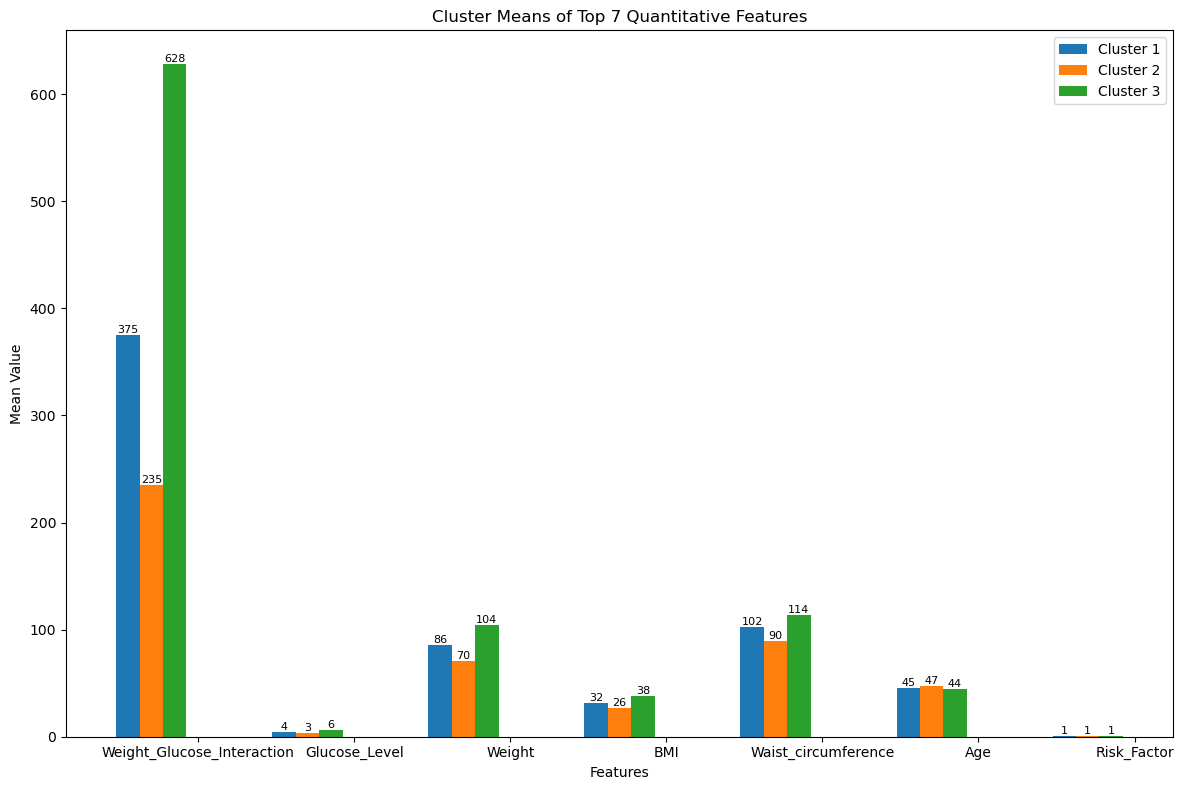

**Figure 1**: Cluster Means of Top 7 Quantitative Features

In [85]:
cluster_meansT = cluster_means7.transpose()

num_clusters = len(cluster_meansT)

bar_width = 0.15

# Set the positions of the bars on the x-axis
positions = np.arange(len(top7_quant_features_array))

plt.figure(figsize=(12, 8))

# Plot each feature's mean for each cluster
for i, (feature_name, feature_means) in enumerate(cluster_meansT.items()):
    # Offset the positions for each cluster
    offset = (i - (num_clusters - 1) / 2) * bar_width
    
    # Plot bars for each cluster
    bars = plt.bar(positions + offset, feature_means, bar_width, label=f'Cluster {i+1}')
    
    # Add labels with values on top of the bars
    for bar, mean_value in zip(bars, feature_means):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{mean_value:.0f}', 
                 ha='center', va='bottom', rotation=0,fontsize=8)

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Cluster Means of Top 7 Quantitative Features')
plt.xticks(positions, top7_quant_features_array, rotation=0)
plt.legend()

plt.tight_layout()
plt.show()
display(Markdown("**Figure 1**: Cluster Means of Top 7 Quantitative Features"))

### Results - Stacked Bar Plots - Qualitative Visualization

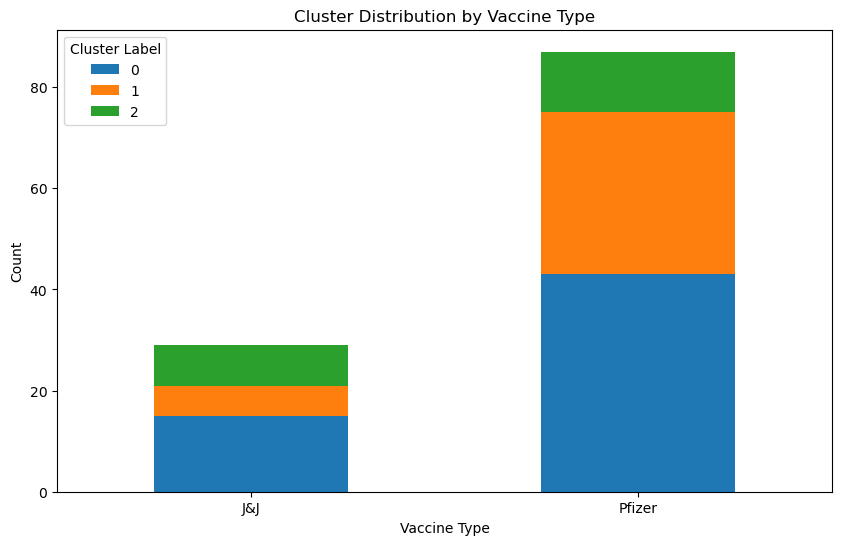

In [86]:
# Group by Vaccine_Type and Cluster_Label, then count occurrences
vaccine_cluster_counts = X3.groupby(['Vaccine_Type', 'cluster_label']).size().unstack(fill_value=0)

# Plotting
vaccine_cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Vaccine Type')
plt.ylabel('Count')
plt.title('Cluster Distribution by Vaccine Type')
plt.legend(title='Cluster Label')
plt.xticks(rotation=0)

plt.show()

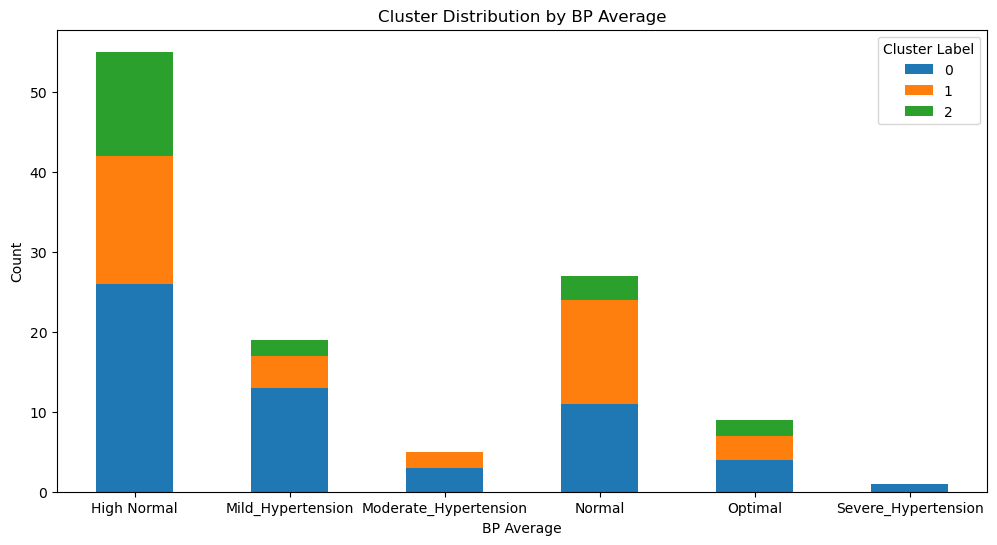

**Figure 3**: Cluster Distribution by BP Average

In [87]:
# Group by BP_Average and Cluster_Label, then count occurrences
bp_cluster_counts = X3.groupby(['BP_Average', 'cluster_label']).size().unstack(fill_value=0)

# Plotting
bp_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('BP Average')
plt.ylabel('Count')
plt.title('Cluster Distribution by BP Average')
plt.legend(title='Cluster Label')
plt.xticks(rotation=0)

plt.show()
display(Markdown("**Figure 3**: Cluster Distribution by BP Average"))

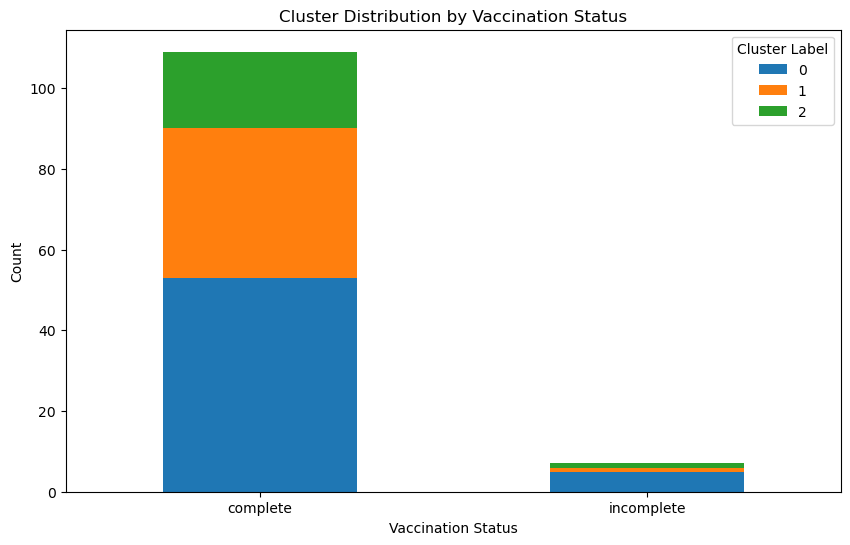

**Figure 4**: Cluster Distribution by Vaccination Status

In [88]:
# Group by Vaccination_Status and Cluster_Label, then count occurrences
vaccination_cluster_counts = X3.groupby(['Vaccination_Status', 'cluster_label']).size().unstack(fill_value=0)

# Plotting
vaccination_cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Vaccination Status')
plt.ylabel('Count')
plt.title('Cluster Distribution by Vaccination Status')
plt.legend(title='Cluster Label')
plt.xticks(rotation=0)

plt.show()
display(Markdown("**Figure 4**: Cluster Distribution by Vaccination Status"))

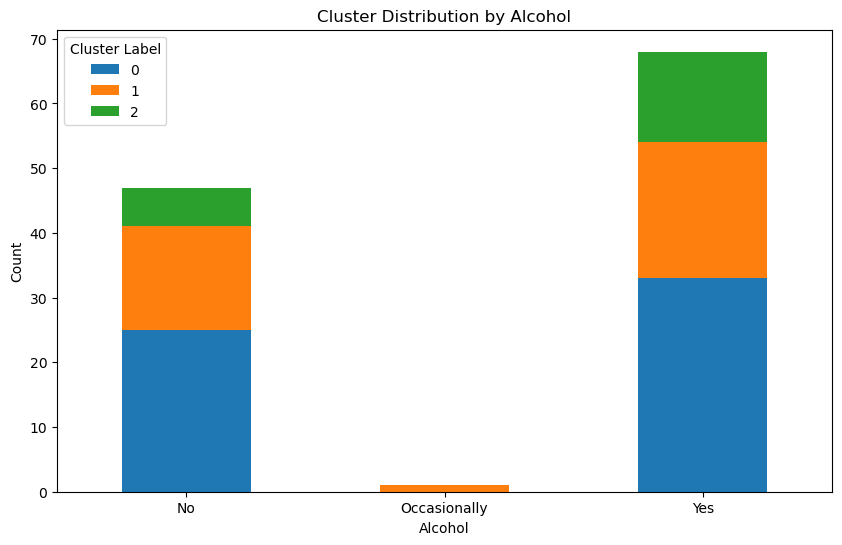

**Figure 5**: Cluster Distribution by Alcohol

In [89]:
# Group by Alcohol and Cluster_Label, then count occurrences
alcohol_cluster_counts = X3.groupby(['Alcohol', 'cluster_label']).size().unstack(fill_value=0)

# Plotting
alcohol_cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Alcohol')
plt.ylabel('Count')
plt.title('Cluster Distribution by Alcohol')
plt.legend(title='Cluster Label')
plt.xticks(rotation=0)

plt.show()
display(Markdown("**Figure 5**: Cluster Distribution by Alcohol"))

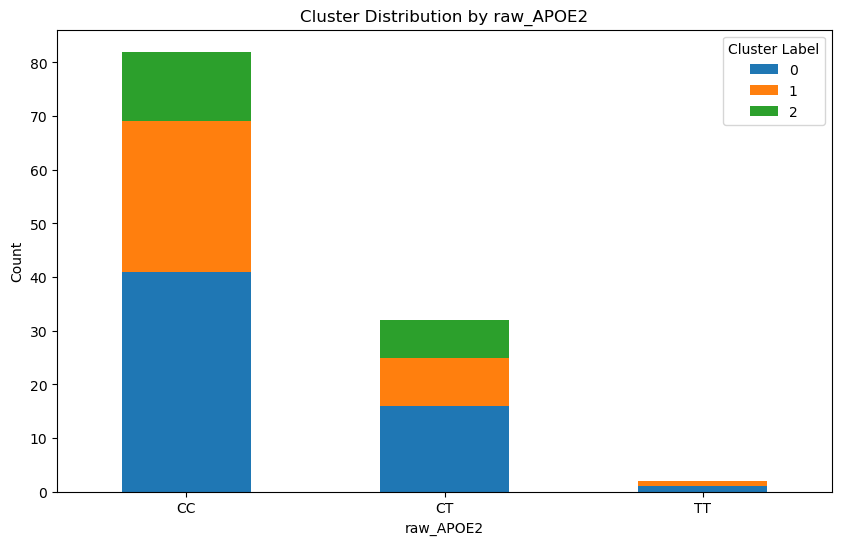

**Figure 6**: Cluster Distribution by raw_APOE2

In [90]:
# Group by raw_APOE2 and Cluster_Label, then count occurrences
raw_apoe2_cluster_counts = X3.groupby(['raw_APOE2', 'cluster_label']).size().unstack(fill_value=0)

# Plotting
raw_apoe2_cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('raw_APOE2')
plt.ylabel('Count')
plt.title('Cluster Distribution by raw_APOE2')
plt.legend(title='Cluster Label')
plt.xticks(rotation=0)

plt.show()
display(Markdown("**Figure 6**: Cluster Distribution by raw_APOE2"))

### Summary Tables of Categorical Features
The individual categorical plots are useful to see an overview of distribution but we might want a quick way to read the values. Here are the summary tables of raw categorical data.

This code helps us create the column headings. We will reuse it in a function `summarize_categorical_features` that traverses our decoded dataframe and retrieves the summary values. 

In [91]:
raw_cat_columns = ['Feature', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 1 %', 'Cluster 2 %', 'Cluster 3 %']
raw_cat_distributions = pd.DataFrame(columns=raw_cat_columns)
raw_cat_distributions

,Feature,Cluster 1,Cluster 2,Cluster 3,Cluster 1 %,Cluster 2 %,Cluster 3 %


In [92]:
def summarize_categorical_features(df, cluster_col, features, real_names=None):
    """
    Summarizes the categorical features in the dataframe by clusters.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing the features and cluster labels.
        cluster_col (str): The column name representing the cluster labels.
        features (list): A list of feature column names to summarize.
        real_names (list, optional): A list of real feature names to use in the summary. 
        If not provided, use feature names from df.
        
    Returns:
        pd.DataFrame: A dataframe with the summarized categorical distributions by clusters.
    """
    raw_cat_columns = ['Feature', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                       'Cluster 1 %', 'Cluster 2 %', 'Cluster 3 %']
    raw_cat_distributions = pd.DataFrame(columns=raw_cat_columns)

    rows_to_append = [['Categorical Values', '', '', '', '', '', '']]

    for i, feature in enumerate(features):
        # using feature names if they are provided
        feature_name = real_names[i] if real_names is not None else feature
        
        # adding feature header to table
        rows_to_append.append([feature_name, '', '', '', '', '', ''])

        # unique values of the feature
        unique_values = df[feature].unique()

        # iterating over unique values
        for value in unique_values:
            counts = [value] + [0] * (len(raw_cat_columns) - 1)  # Initialize counts with feature value

            # counting occurrences for each cluster separately
            for j in range(3):
                count = df[(df[cluster_col] == j) & (df[feature] == value)].shape[0]
                total = df[df[cluster_col] == j].shape[0]
                percentage = (count / total * 100) if total > 0 else 0
                counts[j + 1] = count
                counts[j + 4] = f"{percentage:.2f}%"

            # appending counts to rows_to_append
            rows_to_append.append(counts)

    # creating DataFrame from list of rows to append
    new_rows_df = pd.DataFrame(rows_to_append, columns=raw_cat_columns)

    # concatenating new rows to existing DataFrame
    raw_cat_distributions = pd.concat([raw_cat_distributions, new_rows_df], ignore_index=True)

    return raw_cat_distributions

In [93]:
features_to_summarize = ['break_through','BP_Average', 'Gender_x', 'Alcohol','Vaccine_Type']
real_names = ['Breakthrough Infection','Blood Pressure Average', 'Gender', 'Alcohol Consumption','Vaccine']

In [94]:
summary_df = summarize_categorical_features(X3, 'cluster_label', features_to_summarize, real_names=real_names)
display(Markdown("**Table 6**: Summary of raw categorical values and their distribution in each cluster"))
summary_df

**Table 6**: Summary of raw categorical values and their distribution in each cluster

,Feature,Cluster 1,Cluster 2,Cluster 3,Cluster 1 %,Cluster 2 %,Cluster 3 %
0,Categorical Values,,,,,,
1,Breakthrough Infection,,,,,,
2,No,37,31,17,63.79%,81.58%,85.00%
3,Yes,21,7,3,36.21%,18.42%,15.00%
4,Blood Pressure Average,,,,,,
5,High Normal,26,16,13,44.83%,42.11%,65.00%
6,Normal,11,13,3,18.97%,34.21%,15.00%
7,Mild_Hypertension,13,4,2,22.41%,10.53%,10.00%
8,Optimal,4,3,2,6.90%,7.89%,10.00%
9,Moderate_Hypertension,3,2,0,5.17%,5.26%,0.00%


### Summary Table of Quantitative Features
We can display the mean of the top quantitative variables here to aid our analysis too

In [95]:
cluster_means7.transpose()

,Cluster 1,Cluster 2,Cluster 3
Weight_Glucose_Interaction,375.224,235.368,628.40
Glucose_Level,4.448,3.447,6.15
Weight,85.517,70.289,104.15
BMI,31.741,26.395,38.35
Waist_circumference,102.000,89.605,113.60
Age,45.259,47.132,44.15
Risk_Factor,0.569,0.579,0.70


Breakthrough per Vaccine Type

In [96]:
final_distr

,Cluster,Pfizer,J&J,Pfizer_BKI (%),J&J_BKI (%)
0,1,43,15,39.535,26.667
1,2,32,6,18.750,16.667
2,3,12,8,8.333,25.000


### Breakthrough Infection (BKI) Analysis
Observations based on Profile characteristics of Vaccinated Persons and BKI

**Cluster 1**  
Cluster 1 has the highest Breakthrough Infection (BKI) Rate of (36.2%).  
Pfizer is the predominant vaccine type and it has the higher BKI of 39.5% as compared to J&J.   
These people has overweight particpants with BMI mean of 31, they also have fair glucose levels (4.4mmol).  
This cluster has more people with High Normal and Mild Hypertension compared to other clusters.   
There are also higher instances of alcohol consumption in this cluster, although the percentage of Yes (56.9%) is similar to cluster 2's distribution.   
Risk factors range from 0-5, the highest in the dataset is 2 and cluster 1 exhibits the lowest risk factor of mean of 0.569.

**Cluster 2**  
Cluster 2 has a fairly low Breakthrough Infection (BKI) Rate of (18.42%).  
These cluster has less overweight particpants with BMI average of 26, likewise they have the lowest glucose levels (3.4mmol).  
Pfizer is the predominant vaccine type and it has the higher BKI of 18.75% as compared to J&J.  
The common blood pressures in this cluster are High Normal and Normal.   
High instances of alcohol consumption in this cluster (Yes - 55.3%) similar to 1's distribution.   
Cluster 2 exhibits the second lowest risk factor of 0.579.

**Cluster 3**  
Cluster 3 has the lowest Breakthrough Infection (BKI) Rate of (15%).  
Vaccine types are balanced between Pfizer and J&J, Pfizer BKI is 8.333%.  
These cluster has obese particpants with BMI average of 38, likewise, they have the highest glucose levels (6.2mmol).  
High Normal blood pressure is the most common here.  
This cluster surpisingly has the highest rate of alcohol consumption (70%). But this could be because the cluster has the least people, ie. 20.   
Cluster 3 also has the highest risk factor average of 0.7 surprisingly. Having no boosters or no vaccination add 1 to risk factor so it could be that these people are immune and did not take boosters but drink alcohol or are close to someone with covid or are exposured to some hazardous environments.

**Quick Summary**  
Cluster 1 has overweight participants and it shows the highest breakthrough infection rate regardless of Vaccine Type, moderate alcohol consumption and higher instances of High Normal and Mild Hypertension.  
Cluster 2 has less overweight participants and has a moderate breakthrough infection rate, higher alcohol consumption, predominantly female, and a higher prevalence of High Normal and Normal blood pressure.  
Cluster 3 has obese participants and it has the lowest breakthrough infection rate, most balanced vaccine distribution, highest alcohol consumption and a strong presence of High Normal blood pressure participants.  
**Important:** These observations suggest that weight category, alcohol consumption and blood pressure categories are notable factors influencing breakthrough infection rates in the clusters.

**Note:** The idea of engineering risk factor scores makes sense but we can ignore them in analysis since the values do not vary much. We expected 0-5 but our average is from 0.5 to 0.7

# Phase 6
Summary & Conclusion

### Key Insights

1. Cluster 3 seems to have individuals characterised by high covid 19 immunity although they are obese. It appears having a high normal blood pressure category and some other genetic factors we don't know reduce their average breakthrough rate to as low as 16.5%, ie. (25+8)/2 calculated by averaging BKI rates across vaccines in Table 3. We cannot safely conclude that obese people are the most immune however because the data is misleading. For example it tells us that people with high alcohol usage (70%) have lower break through infection rates. We can use the Central Limit Theorem (CLT) in statistics to make a case against the validity of this insight. Since cluster 3 has only 20 participants we can conclude based on CLT that its observations are not normally distributed, hence we can say the fact that higher alcohol usage increases immunity is invalid.
2. Cluster 1 has overweight individuals and these people exhibit higher Breakthrough Infection (BKI) rates than people in Cluster 2 which has less overweight people (people closer to normal weight). This means the less obese you are, the less chance you have of a break through infection.
3. Following from Key Insight 1 and 2, Cluster 2 is the best cluster understand the characteristics of individuals with lower breakthrough rates. For example, we can introduce more features into the pipeline that we did not use to see how they differ in amongst the clusters.
4. There is a tradeoff between the type of vaccine used, there is no one size fits all approach. We may be tempted to conclude that J&J is the best vaccine since is leads to generally lower Breakthrough Infection (BKI) Rates - ie. 18.750% and 16.667% in cluster 1 and 2, however we see that Pfizer is more effective for people in cluster 3, who are obese.
5. Unlike we expected, symptopms and risk factor scores which we engineered by augmentation hardly contribute to factors that determine whether a participant will have a breakthrough infection.

### Implications

The key insights from our unsupervised learning on the dataset has some implications for health practicioners, On the base level, our machine learning results can be used to inform Vaccination Strategies. Regarding Health Monitoring and Tailored Interventions, the results from this machine learning can be extended into related future studies.  
**Vaccination Strategy**:
The most effective Vaccine Type depends on the weight of the patients. So when new patients come for treatment, practioners can classify them into their weight profiles and obese patients will be primarly treated with Pfizer and overweight and normal weights will be primarily treated with J&J. 
Monitoring and possibly additional protection measures for those vaccinated with Pfizer in Cluster 1.  
**Health Monitoring**:
Health practicioners can monitor primarily Glucose Levels of individuals and give them medications that keeps their glucose levels in a range that will prevent them from getting a breakthrough infection. Other important vitals like Haptoglobin (HPT), Blood Sugar and Cholestrol and even other vitals which are not in our data set could also be introduced into the pipeline so medications can be prescribed to keep these vitals at optimal levels.  
**Tailored Interventions**:
Now we know the most important features for influencing Breakthrough Infection (BKI) rates are Weight Category, Alcohol Consumption, Blood Pressure Categories and Vaccine Type, we can extend this study by introducing more features into the pipeline and idenfying how these less important but more specific features to help us understand how fluctuations in less important features will affect breakthrough rates. This will help health practicioners provide tailored interventions to people with unique health profiles. This tailored approach will boost healthcare effectiveness because a personalized approach can be given for post-vaccination care.

### Benefits of AI
Explaining the benefits of using AI and XAI for this type of analysis

Using AI, particularly Explainable AI (XAI), for this medical analysis offers several benefits.   
**Data-Driven Insights**:
AI allows us to process and analyse large datasets to uncover patterns and correlations that humans might not discover manually or might take too long to do. In relation to this health analysis, AI helps us understand the intricate interactions between various health metrics and vaccination outcomes.  
**Explainability and Transparency**:
XAI gives us an unbiased way to determine feature importances that makes it easier for health practitioners to trust the results. Assuming a doctor had to explain clusters, they might use their domain specific knowlegde and this will vary from  doctor to doctor and the cluster explanations will be unreliable.
Aside the SHAPLEY library, we can also use the LIME library highlight the importance of specific features and better understand clustering.   
**Personalized Medicine**:
This is related to the implications above. Because of XAI, health practicioners can provided tailored interventions to individuals.
**Efficiency and Accuracy**:
Using AI can help us automate the machine learning pipeline (cleaning, training, evaluation, tuning, serialization) for datasets. For example, we could refactor the pipeline in this project into an automated form that works on any other applicable dataset we might want to perform health based clustering on. This improves data analysis by reducing the time and effort required compared to manual methods. Imagine we used manual methods that took us a week an realized that there was no meaningful clustering. The speed and accuracy of AI helps us avoid that. 

# References

**Bibliography**  
[1]Centers for Disease Control and Prevention. 2022. Assessing Your Weight. Centers for Disease Control and Prevention. Retrieved July 10, 2024 from https://www.cdc.gov/healthyweight/assessing/index.html#:~:text=If%20your%20BMI%20is%20less  
[2]Wamika Jha. 2021. Implementation of Principal Component Analysis(PCA) in K Means Clustering. Analytics Vidhya. Retrieved July 10, 2024 from https://medium.com/analytics-vidhya/implementation-of-principal-component-analysis-pca-in-k-means-clustering-b4bc0aa79cb6  
[3]KUNAAL NAIK. 2022. P2: sklearn K-Means (Elbow and Silhouette Method). kaggle.com. Retrieved July 10, 2024 from https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method  
[4]Aigerim Shopenova. 2020. Interpret_random_forest_classifier_using_SHAP/Random_forest_classifier_SHAP.ipynb at master · aig3rim/Interpret_random_forest_classifier_using_SHAP. GitHub. Retrieved July 10, 2024 from https://github.com/aig3rim/Interpret_random_forest_classifier_using_SHAP/blob/master/Random_forest_classifier_SHAP.ipynb